##**Imports**

In [ ]:
!pip install mlflow --quiet

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import seaborn as sns
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [6]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

##**Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 1 and 2 (otherwise skip Step 0 and go to Step 1)**

In [7]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1_difVXO-_N1iMFzxMP2IFeD7e8tUhRBV'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './data/processed'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()



Creating folder: ./data/processed/bag
Creating folder: ./data/processed/bag/val_dataset
Creating folder: ./data/processed/bag/val_dataset/7094108079719339233
Creating folder: ./data/processed/bag/val_dataset/7094108079719339233/00000000.shard
Creating folder: ./data/processed/bag/test_dataset
Creating folder: ./data/processed/bag/test_dataset/10708988183537814467
Creating folder: ./data/processed/bag/test_dataset/10708988183537814467/00000000.shard
Creating folder: ./data/processed/bag/train_dataset
Creating folder: ./data/processed/bag/train_dataset/13562169807097260504
Creating folder: ./data/processed/bag/train_dataset/13562169807097260504/00000000.shard
Creating folder: ./data/processed/clothes_new
Creating folder: ./data/processed/clothes_new/test_dataset
Creating folder: ./data/processed/clothes_new/test_dataset/14824926411023993334
Creating folder: ./data/processed/clothes_new/test_dataset/14824926411023993334/00000000.shard
Creating folder: ./data/processed/clothes_new/val_data

In [14]:
PRODUCT_CATEGORY = 'schuhe'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SIZE = (427, 350)
IMG_SHAPE = (427, 350, 3)
BATCH_SIZE = 32
CLASSES = ['schuhe_0_overall_to_right'
           , 'schuhe_1_back'
           , 'schuhe_2_top_or_soul'
           , 'schuhe_3_side_to_left'
           , 'schuhe_4_zoom'
           ]

train_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

In [15]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [11]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
schuhe_0_overall_to_right occurs 155 times
schuhe_1_back occurs 166 times
schuhe_2_top_or_soul occurs 154 times
schuhe_3_side_to_left occurs 159 times
schuhe_4_zoom occurs 134 times


In [16]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
schuhe_0_overall_to_right occurs 44 times
schuhe_1_back occurs 44 times
schuhe_2_top_or_soul occurs 54 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 69 times


In [17]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
schuhe_0_overall_to_right occurs 49 times
schuhe_1_back occurs 35 times
schuhe_2_top_or_soul occurs 46 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 51 times


In [35]:
import numpy as np

train_classes, train_class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)

val_classes, val_class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)

test_classes, test_class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)

# Print summary table
print("| Class                          | Train | Validation | Test |")
print("|------------------------------  |-------|------------|------|")
for class_id in range(len(train_classes)):
    class_name = CLASSES[train_classes[class_id]]
    train_count = train_class_count[class_id]
    val_count = val_class_count[class_id]
    test_count = test_class_count[class_id]
    print(f"| {class_name:<30} | {train_count:<5} | {val_count:<10} | {test_count:<4} |")


| Class                          | Train | Validation | Test |
|------------------------------  |-------|------------|------|
| schuhe_0_overall_to_right      | 155   | 44         | 49   |
| schuhe_1_back                  | 166   | 44         | 35   |
| schuhe_2_top_or_soul           | 154   | 54         | 46   |
| schuhe_3_side_to_left          | 159   | 45         | 45   |
| schuhe_4_zoom                  | 134   | 69         | 51   |


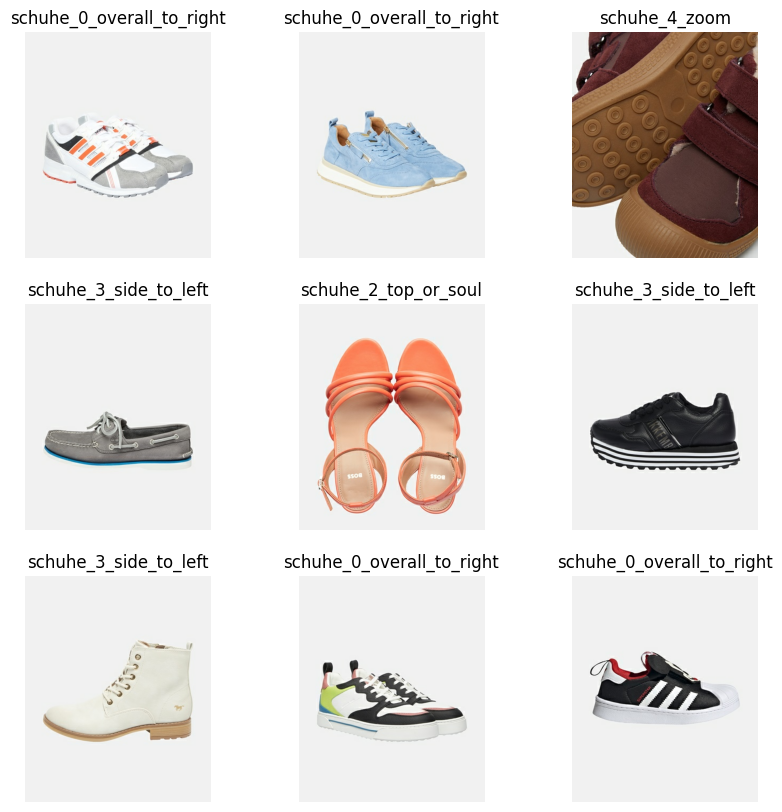

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")


## **Step 1: Importing the Image data from Google drive**

**Note:** we figured out how to download a nested folder structure allong with the files from Google Drive (instead of just one file) from the following StackOverflow discussion - https://stackoverflow.com/questions/46155300/pydrive-error-no-downloadlink-exportlinks-for-mimetype-found-in-metadata

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac'
# Note: these folders should match the final project folder structure we create and may need to be updated
root = './data/raw'
# If the folders that we want to download the images to do not exit then create them as shown below:
os.mkdir('./data')
os.mkdir('./data/raw')

search_folder(folder_id,root+'/')
f.close()

Creating folder: ./data/raw/waesche
Creating folder: ./data/raw/waesche/waesche_2_model_back
Creating folder: ./data/raw/schuhe
Creating folder: ./data/raw/schuhe/schuhe_4_zoom
Creating folder: ./data/raw/schuhe/schuhe_0_overall_to_right
Creating folder: ./data/raw/waesche/waesche_1_zoomed
Creating folder: ./data/raw/schuhe/schuhe_1_back
Creating folder: ./data/raw/schuhe/schuhe_3_side_to_left
Creating folder: ./data/raw/waesche/waesche_0_model_front
Creating folder: ./data/raw/waesche/waesche_3_ghost
Creating folder: ./data/raw/waesche/waesche_4_look
Creating folder: ./data/raw/schuhe/schuhe_2_top_or_soul
Creating folder: ./data/raw/clothes
Creating folder: ./data/raw/clothes/clothes_3_ghost
Creating folder: ./data/raw/clothes/clothes_0_model_front
Creating folder: ./data/raw/clothes/clothes_1_zoomed
Creating folder: ./data/raw/bag
Creating folder: ./data/raw/bag/bag_1_side
Creating folder: ./data/raw/clothes/clothes_4_look
Creating folder: ./data/raw/clothes/clothes_2_model_back
Crea

##**Step 2: Load image data and split them into Train, Validation and Test**

### **Step 2.1: Process the data from Step 1:**

**Note:** there is a script we can run to find corrupted images. We ran this script and found an image (./image_data/raw/clothes/clothes_1_zoomed/32760559-001.jpg') that was corrupted and deleted it from the directory so it does not cause issues down stream when we train our models

In [ ]:
import pathlib
root = './data/raw'
data_dir = pathlib.Path(root)
data_dir

PosixPath('data/raw')

In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (716 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121747 files and directories currently install

In [ ]:
!tree --dirsfirst --filelimit 6 './data/raw'

./data/raw  [error opening dir]

0 directories, 0 files


In [ ]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 0


In [ ]:
clothes_0_model_front = list(data_dir.glob('clothes/clothes_0_model_front/*.jpg'))

In [ ]:
PIL.Image.open(str(clothes_0_model_front[4]))

IndexError: list index out of range

**The script above found one corrupted image in the clothes_1_zoomed folder - './data/raw/clothes/clothes_1_zoomed/32760559-001.jpg'**

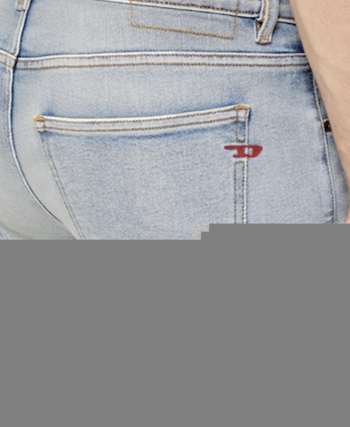

In [ ]:
from struct import unpack
from tqdm import tqdm
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                raise TypeError("issue reading jpeg file")

bads = []

img_dir = root

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
        image = os.path.join(dirName,img)
        image = JPEG(image)
        try:
            image.decode()
        except:
            bads.append(dirName+'/'+img)

#Show the bad images
bads

#remove the bad images
# note: we found the following image that was corrupted that we removed - ./raw/clothes/clothes_1_zoomed/32760559-001.jpg'
# for name in bads:
#   os.remove(name)

In [ ]:
bads

In [ ]:
# Delete the corrupted image from the folder
for name in bads:
  os.remove(name)

In [ ]:
# Image count after deleting the corrupted image
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

###**Step 2.1: Split data into Train, Validatin and Test**

In [ ]:
RANDOM_SEED = 42
#VAL_SPLIT = 0.4
PRODUCT_CATEGORY = 'clothes'
BATCH_SIZE = 32
IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
SHUFFLE = True

PROD_DATA_DIR = pathlib.Path(root+'/'+PRODUCT_CATEGORY)
CLASSES = ['clothes_0_model_front'
           , 'clothes_1_zoomed'
           , 'clothes_2_model_back'
           , 'clothes_3_ghost'
           , 'clothes_4_look'
           ]

# This code gives the classes
# for item in os.scandir(PROD_DATA_DIR):
#     if not item.name.startswith('.'): #dont include any hidden files or dirs that may be in the folder (more applicable when running on local machine)
#         CLASSES.append(item.name)

In [ ]:
CLASSES

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = PROD_DATA_DIR,
  seed=RANDOM_SEED,
  class_names=CLASSES,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = SHUFFLE)

ds_batches = tf.data.experimental.cardinality(full_ds)
train_ds = full_ds.take(((ds_batches) * 3) // 5) #60% of the data for training
val_test_ds = full_ds.skip(((ds_batches) * 3) // 5) #40% of the remaining data for validation and test

val_test_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take((val_test_batches) // 2) #50% of the val_test_ds for validation (20% of full_ds)
test_ds = val_test_ds.skip((val_test_batches) // 2) #50% of the val_test_ds for Test (20% of full_ds)

print(f'Train data size = {len(train_ds)*BATCH_SIZE}')
print(f'Validation data size = {len(val_ds)*BATCH_SIZE}')
print(f'Test data size = {len(test_ds)*BATCH_SIZE}')

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   directory = PROD_DATA_DIR,
#   validation_split=VAL_SPLIT,
#   subset="validation",
#   seed=RANDOM_SEED,
#   class_names=CLASSES,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE,
#   shuffle = SHUFFLE)

In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

###**Step 2.3: Save the Train, Val and Test tensor datasets so it can saved in a Google Drive to be used later. That way we dont have to download all images again and it is muh faster to train a new model with the same data (refer to Step 0)**

In [ ]:
os.mkdir('./data/processed')
os.mkdir('./data/processed/clothes')
tf.data.experimental.save(train_ds, './data/processed/clothes/train_dataset')
tf.data.experimental.save(val_ds, './data/processed/clothes/val_dataset')
tf.data.experimental.save(test_ds, './data/processed/clothes/test_dataset')

In [ ]:
# Check that the label and images match
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

## **Step 3: Create and train the base CNN model**

In [21]:
# The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def create_base_model(activation, initializer, regularizer, dropout_rate):
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),

      tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(256, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

# Optimizers




1. Training model with activation = relu, initializer = glorot_uniform, regulizer = None and dropout_rate=0.0
Epoch 1/20
24/24 [==============================] - 17s 335ms/step - loss: 6.0176 - accuracy: 0.4349 - val_loss: 0.8188 - val_accuracy: 0.7188
Epoch 2/20
24/24 [==============================] - 5s 194ms/step - loss: 0.6316 - accuracy: 0.7982 - val_loss: 0.4370 - val_accuracy: 0.8672
Epoch 3/20
24/24 [==============================] - 4s 189ms/step - loss: 0.3514 - accuracy: 0.9102 - val_loss: 0.3182 - val_accuracy: 0.9023
Epoch 4/20
24/24 [==============================] - 4s 183ms/step - loss: 0.2227 - accuracy: 0.9440 - val_loss: 0.2807 - val_accuracy: 0.9180
Epoch 5/20
24/24 [==============================] - 4s 180ms/step - loss: 0.1844 - accuracy: 0.9518 - val_loss: 0.2777 - val_accuracy: 0.9023
Epoch 6/20
24/24 [==============================] - 4s 183ms/step - loss: 0.1602 - accuracy: 0.9609 - val_loss: 0.2366 - val_accuracy: 0.9258
Epoch 7/20
24/24 [=================

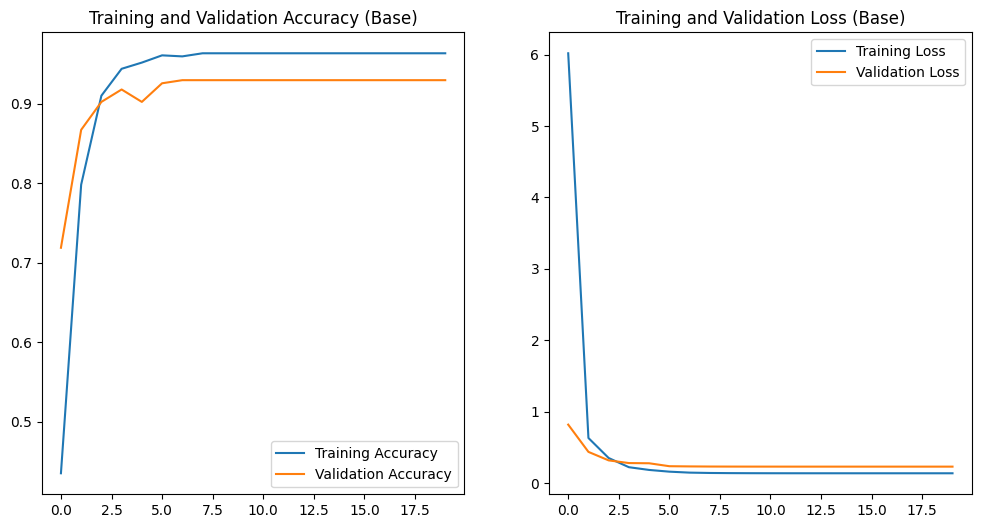

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 231ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  2.06it/s]

1/1 [==============================] - 0s 114ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:01,  3.03it/s]

1/1 [==============================] - 0s 99ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  3.65it/s]

1/1 [==============================] - 0s 95ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:01<00:00,  4.04it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  4.49it/s]

1/1 [==============================] - 0s 67ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  4.66it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  5.14it/s]

1/1 [==============================] - 0s 429ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]



Accuracy of base model on test data: 94.69%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.98      0.96      0.97        49
            schuhe_1_back       0.92      0.94      0.93        35
     schuhe_2_top_or_soul       0.95      0.91      0.93        46
    schuhe_3_side_to_left       0.89      0.93      0.91        45
            schuhe_4_zoom       0.98      0.98      0.98        51

                 accuracy                           0.95       226
                macro avg       0.94      0.95      0.95       226
             weighted avg       0.95      0.95      0.95       226



2. Training model with activation = relu, initializer = glorot_normal, regulizer = None and dropout_rate=0.0
Epoch 1/20


24/24 [==============================] - 6s 207ms/step - loss: 4.8296 - accuracy: 0.4154 - val_loss: 0.7891 - val_accuracy: 0.7344
Epoch 2/20
24/24 [==============================] - 4s 183ms/step - loss: 0.6199 - accuracy: 0.8203 - val_loss: 0.4816 - val_accuracy: 0.8516
Epoch 3/20
24/24 [==============================] - 5s 197ms/step - loss: 0.3646 - accuracy: 0.8906 - val_loss: 0.3561 - val_accuracy: 0.8711
Epoch 4/20
24/24 [==============================] - 4s 181ms/step - loss: 0.2414 - accuracy: 0.9284 - val_loss: 0.3287 - val_accuracy: 0.9023
Epoch 5/20
24/24 [==============================] - 4s 183ms/step - loss: 0.2158 - accuracy: 0.9362 - val_loss: 0.2859 - val_accuracy: 0.9219
Epoch 6/20
24/24 [==============================] - 4s 183ms/step - loss: 0.1922 - accuracy: 0.9505 - val_loss: 0.2791 - val_accuracy: 0.9219
Epoch 7/20
24/24 [==============================] - 4s 181ms/step - loss: 0.1829 - accuracy: 0.9531 - val_loss: 0.2732 - val_accuracy: 0.9219
Epoch 8/20
24/24 

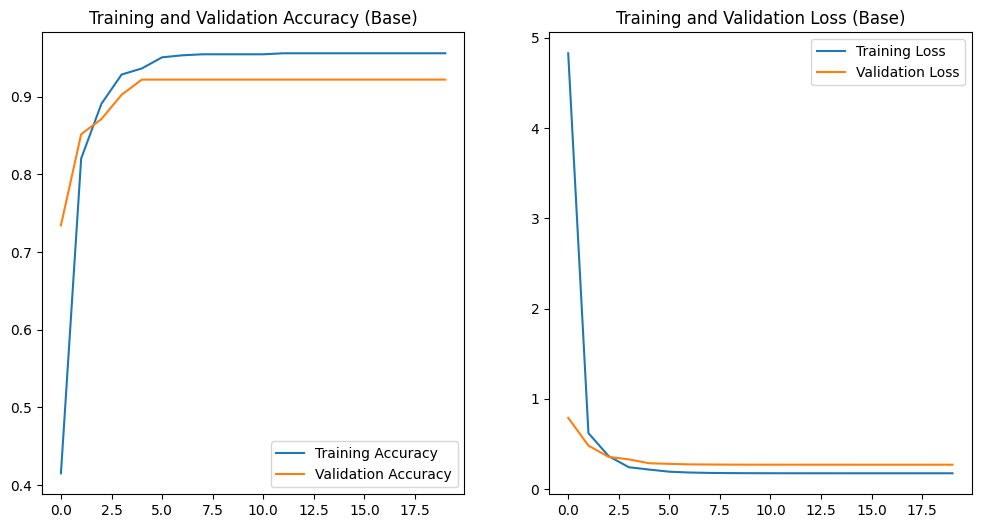

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 199ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  2.04it/s]

1/1 [==============================] - 0s 95ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:02,  2.93it/s]

1/1 [==============================] - 0s 107ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  3.53it/s]

1/1 [==============================] - 0s 105ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:01<00:01,  3.84it/s]

1/1 [==============================] - 0s 70ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  4.13it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  4.37it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  4.54it/s]

1/1 [==============================] - 0s 77ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]




Accuracy of base model on test data: 93.81%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.96      0.96      0.96        49
            schuhe_1_back       0.91      0.91      0.91        35
     schuhe_2_top_or_soul       0.93      0.91      0.92        46
    schuhe_3_side_to_left       0.89      0.91      0.90        45
            schuhe_4_zoom       0.98      0.98      0.98        51

                 accuracy                           0.94       226
                macro avg       0.94      0.94      0.94       226
             weighted avg       0.94      0.94      0.94       226



3. Training model with activation = relu, initializer = he_normal, regulizer = None and dropout_rate=0.0
Epoch 1/20
24/24 [==============================] - 7s 226ms/step - loss: 24.9341 - accuracy: 0.4167 - val_loss: 0.7978 - val_accuracy: 0.7539
Epoch 2/20
24/24 [==============================] - 4s 181ms/step - loss: 0.5019 - accuracy: 0.834

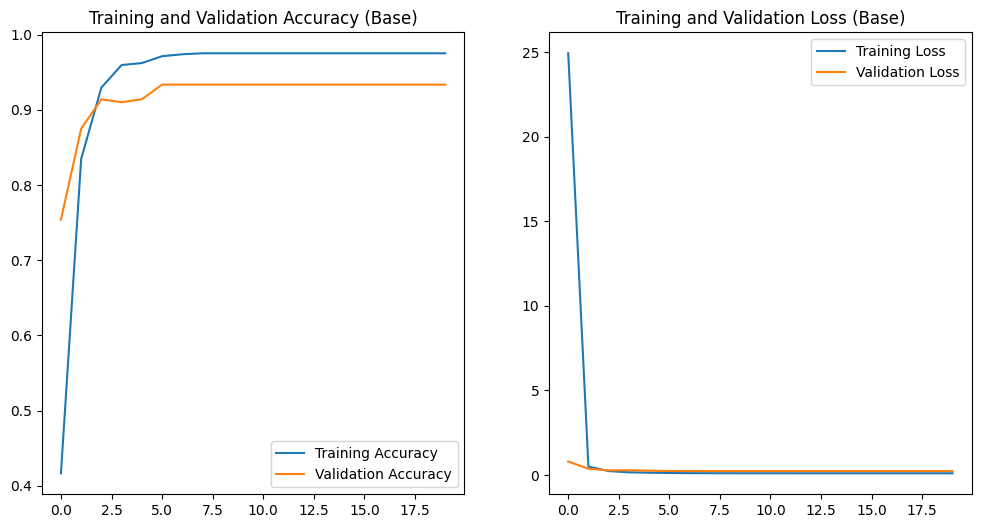

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 17 calls to <function Model.make_predict_function.<locals>.predict_function at 0x793e11e3f520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 209ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  2.23it/s]

1/1 [==============================] - 0s 105ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:01,  3.07it/s]

1/1 [==============================] - 0s 97ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  3.52it/s]

1/1 [==============================] - 0s 96ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:01<00:01,  3.99it/s]

1/1 [==============================] - 0s 77ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  4.47it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  5.00it/s]

1/1 [==============================] - 0s 69ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  4.99it/s]

1/1 [==============================] - 0s 81ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]



Accuracy of base model on test data: 95.13%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.96      0.94      0.95        49
            schuhe_1_back       0.89      0.94      0.92        35
     schuhe_2_top_or_soul       0.98      0.93      0.96        46
    schuhe_3_side_to_left       0.93      0.96      0.95        45
            schuhe_4_zoom       0.98      0.98      0.98        51

                 accuracy                           0.95       226
                macro avg       0.95      0.95      0.95       226
             weighted avg       0.95      0.95      0.95       226



4. Training model with activation = relu, initializer = lecun_normal, regulizer = None and dropout_rate=0.0
Epoch 1/20


24/24 [==============================] - 6s 206ms/step - loss: 10.9279 - accuracy: 0.5052 - val_loss: 0.6661 - val_accuracy: 0.7930
Epoch 2/20
24/24 [==============================] - 4s 184ms/step - loss: 0.5153 - accuracy: 0.8503 - val_loss: 0.3963 - val_accuracy: 0.8633
Epoch 3/20
24/24 [==============================] - 4s 185ms/step - loss: 0.2340 - accuracy: 0.9206 - val_loss: 0.2862 - val_accuracy: 0.8984
Epoch 4/20
24/24 [==============================] - 4s 184ms/step - loss: 0.1596 - accuracy: 0.9505 - val_loss: 0.2412 - val_accuracy: 0.9297
Epoch 5/20
24/24 [==============================] - 4s 185ms/step - loss: 0.1211 - accuracy: 0.9714 - val_loss: 0.2290 - val_accuracy: 0.9219
Epoch 6/20
24/24 [==============================] - 4s 182ms/step - loss: 0.1080 - accuracy: 0.9701 - val_loss: 0.1997 - val_accuracy: 0.9375
Epoch 7/20
24/24 [==============================] - 4s 177ms/step - loss: 0.0996 - accuracy: 0.9753 - val_loss: 0.2030 - val_accuracy: 0.9375
Epoch 8/20
24/24

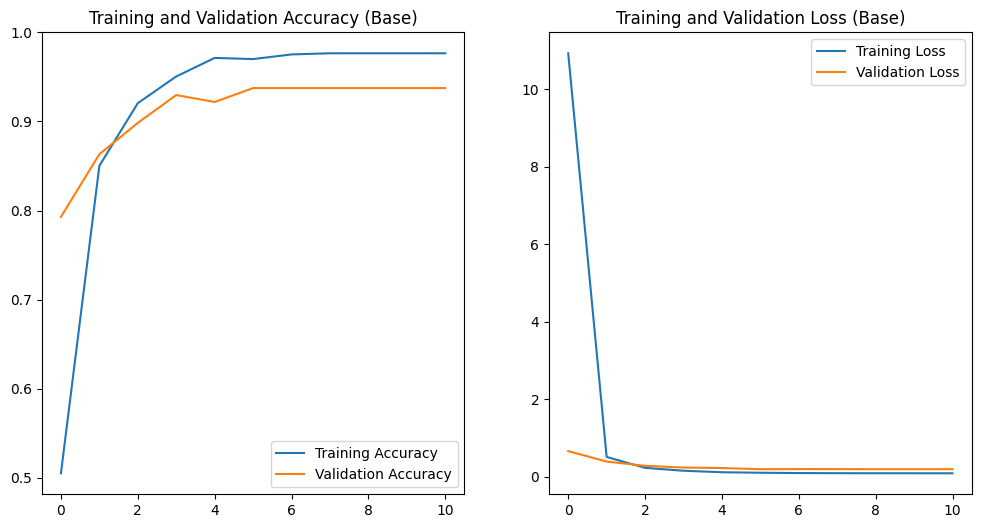

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 17 calls to <function Model.make_predict_function.<locals>.predict_function at 0x793e0cefcca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 242ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  1.98it/s]

1/1 [==============================] - 0s 145ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:02,  2.77it/s]

1/1 [==============================] - 0s 97ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:01<00:01,  3.26it/s]

1/1 [==============================] - 0s 94ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:01<00:01,  3.61it/s]

1/1 [==============================] - 0s 69ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  3.93it/s]

1/1 [==============================] - 0s 76ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  4.44it/s]

1/1 [==============================] - 0s 70ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  4.99it/s]

1/1 [==============================] - 0s 111ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]



Accuracy of base model on test data: 95.13%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.92      0.98      0.95        49
            schuhe_1_back       0.97      0.94      0.96        35
     schuhe_2_top_or_soul       0.98      0.93      0.96        46
    schuhe_3_side_to_left       0.91      0.93      0.92        45
            schuhe_4_zoom       0.98      0.96      0.97        51

                 accuracy                           0.95       226
                macro avg       0.95      0.95      0.95       226
             weighted avg       0.95      0.95      0.95       226



,Activation,Initializer,Regularizer,Dropout,Accuracy_Score
0,relu,glorot_uniform,None,0.0,94.690265
1,relu,glorot_normal,None,0.0,93.805310
2,relu,he_normal,None,0.0,95.132743
3,relu,lecun_normal,None,0.0,95.132743


In [23]:
ACTIVATIONS = ['relu'
               #, 'leaky_relu'
               #, 'elu'
               #, 'tanh'
               #, 'selu'
              ]
INITIALIZERS = ['glorot_uniform'
                , 'glorot_normal'
                , 'he_normal'
                , 'lecun_normal'
               ]
KERNEL_REGULARIZERS = [None
                      #  , 'l1'
                      #  , 'l2'
                      #  , 'l1_l2'
                      ]

DROPOUT_RATE = [0.0] #0.2, #0.25

EPOCHS = 20

INITIAL_LEARNING_RATE = 0.001
FINAL_LEARNING_RATE = 0.00001
LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/EPOCHS)
STEPS_PER_EPOCH = len(test_ds) # this should actually be set to int(train_size/batch_size), but since the len(test_ds) returns the number of training records divided by the batch size already we just set it to that

# LR_SCHEDULE = 0.0001

training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Accuracy_Score'])

i=0
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer} and dropout_rate={dropout_rate}')
                print("="*80)

                model_base = create_base_model(activation, initializer, regularizer, dropout_rate)

                LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate = INITIAL_LEARNING_RATE,
                    decay_steps = STEPS_PER_EPOCH,
                    decay_rate=LEARNING_RATE_DECAY_FACTOR,
                    staircase=True)

                model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                              loss="sparse_categorical_crossentropy",
                              metrics=['accuracy'])

                early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

                history_base = model_base.fit(
                                x=train_ds,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                verbose="auto",
                                callbacks=[early_stopping_cb],
                                validation_data=val_ds
                                # class_weight=None,
                                # sample_weight=None,
                                # initial_epoch=0,
                                # steps_per_epoch=None,
                                # validation_steps=None,
                                # validation_batch_size=None,
                                # validation_freq=1,
                            )

                plot_accuracy_loss(history_base)

                y_true, y_pred = eval_model_on_test(model_base, test_ds)
                score = (accuracy_score(y_true, y_pred)*100)
                print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                print(classification_report(y_true, y_pred, target_names=CLASSES))
                #conf_matrix = confusion_matrix(y_true, y_pred)
                pd.DataFrame(confusion_matrix(y_true, y_pred))
                #conf_df = pd.DataFrame(conf_matrix, index=CLASSES, columns=CLASSES)
                new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Accuracy_Score' : score}
                training_results_df.loc[len(training_results_df)] = new_row
                i += 1

print("="*80)
training_results_df

In [24]:
model_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 427, 350, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 427, 350, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 213, 175, 32)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 213, 175, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 213, 175, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 106, 87, 64)       0         
 ng2D)                                                

In [29]:
#model_base.save('Schuhe_CNN_best_model.h5') # relu_lecun_normal_None_0.0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_baseline_cnn_model.h5", save_best_only=True)

history_base = model_base.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds)

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9753

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 11s 469ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
Epoch 2/20
24/24 [==============================] - 4s 165ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
Epoch 3/20
24/24 [==============================] - 4s 167ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
Epoch 4/20
24/24 [==============================] - 4s 165ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
Epoch 5/20
24/24 [==============================] - 4s 165ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
Epoch 6/20
24/24 [==============================] - 4s 186ms/step - loss: 0.0999 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9375
